In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Measure and improve

How do we know that search engine's quality improved (or at least haven't deteriorated) because of our changes?

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. 11-Point Interpolated Average
3. Normalized Discounted Cumulative Gain (NDCG)
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## 1.1. [10] Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top $k$ documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). 
Assume we have a bucket $Q$ of queries $q_j\in Q$.
If the set of **relevant documents** for an information need (query) $q_j$ is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.

**NB** Don't make the name of [the metric confuse you](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52). *Average Precision* is the term, which corresponds to the area under precision-recall curve. It's computation is tricky. We suggest to start with implementing [$AveP$](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision).

In [21]:
def mask_relevance(search_result, relevance):
    """
    Calculates a binary mask (NDarray consisting of either 0 or 1)
    each bit of which corresponds to whether a document on this position
    is relevant

    Args:
        - `search_result`: list of ranked results for each query [doc_id1, doc_id2, ...]
        - `relevance`:  list, [(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.ndarray` - relevance bitmask 
    """
    N = len(search_result)
    relevance_mask = np.zeros(N)
    # Generate relevance mask based on presence in relevance dictionary
    relevance_mask[(np.array(relevance) - 1)[:, 0]] = 1
    # Rearrange the mask according to the order in `search_result`
    relevance_mask = relevance_mask[np.array(search_result) - 1]
    return relevance_mask

def precision(search_result, relevance):
    """
    Calculates point-wise precision for given query 

    Args:
        - `search_result`: list of ranked results for each query [doc_id1, doc_id2, ...]
        - `relevance`:  list, [(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.ndarray` - point-wise precision
    """
    N = len(search_result)
    relevance_mask = mask_relevance(search_result, relevance)
    precision = np.zeros(N)
    # Calculate point-wise precision
    for p in range(N):
        precision[p] = relevance_mask[:(1 + p)].sum() / (1 + p)
    return precision

def average_precision(search_result, relevance):
    """
    Calculates AveP metric

    Args:
        - `search_result`: list of ranked results for each query [doc_id1, doc_id2, ...]
        - `relevance`:  list, [(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.float64` - average precision among query

    """
    mask = mask_relevance(search_result, relevance)
    # Sum over p(r) * dr
    return (precision(search_result, relevance)[mask.astype(bool)].sum() / (mask.sum())).astype(np.float64)

def mean_avg_precision(search_results, relevance):
    """
    Calculates mAP metric

    Args:
        - `search_results`: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
        - `relevance`: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.float64` - average precision among all queries

    """
    zipped = [(search_results[i], relevance[i + 1]) for i in range(len(search_results))]
    return np.mean(list(map(lambda x: average_precision(*x), zipped))).astype(np.float64)

### 1.1.1. Tests

In [22]:
test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285714


## 1.2. [15] 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [23]:
def recall(search_result, relevance):
    """
    Calculates point-wise recall for given query 

    Args:
        - `search_result`: list of ranked results for each query [doc_id1, doc_id2, ...]
        - `relevance`:  list, [(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.ndarray` - point-wise recall
    """
    N = len(search_result)
    relevance_mask = mask_relevance(search_result, relevance)
    M = relevance_mask.sum()
    r = np.zeros(N)
    # Calculate point-wise precision
    for p in range(N):
        r[p] = relevance_mask[:(1 + p)].sum()
    return np.divide(r, M).astype(np.float64)

def interpolate11(precision: np.ndarray, recall: np.ndarray): 
    """
    Calculates 11-point interpolation for a single query (precision/recall pair)

    Args:
        - `precision`:  np.ndarray, pre-calculated point-wise precision array
        - `recall`:     np.ndarray, pre-calculated point-wise precision recall

    Returns:
        - `numpy.ndarray` - array of 11 elements: interpolated precision 
    """
    p_inter = np.zeros(11)
    for i, r in enumerate(np.linspace(0, 1, num=11)):
        p_inter[i] = precision[recall >= r].max()
    return p_inter

        
def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    """
    Calculates average 11-point interpolation for a query

    Args:
        - `search_results`: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
        - `relevance`: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

    Returns:
        - `numpy.ndarray` - array of 11 elements: average interpolated precision 
    """
    zipped = [(search_results[i], relevance[i + 1]) for i in range(len(search_results))]
    p_inter = []
    
    for result, relev in zipped:
        p = precision(result, relev)
        r = recall(result, relev)
        p_inter.append(interpolate11(p, r))
    result = np.mean(np.array(p_inter), axis=0)
    if plot:
        sns.lineplot(x=np.linspace(0, 1, 11), y=result)
        plt.show()

    return result

In [24]:
result = test_results[0]
relevance = test_relevance[1]
mask = mask_relevance(result, relevance)
p = precision(result, relevance)
r = recall(result, relevance)
p_inter = interpolate11(p, r)
with np.printoptions(linewidth=200, precision=1):
    print(np.vstack((mask, p, r)))
    print(p_inter)

[[0.  0.  0.  0.  1.  0.  1.  1.  0.  0. ]
 [0.  0.  0.  0.  0.2 0.2 0.3 0.4 0.3 0.3]
 [0.  0.  0.  0.  0.3 0.3 0.7 1.  1.  1. ]]
[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]


### 1.2.1.Tests

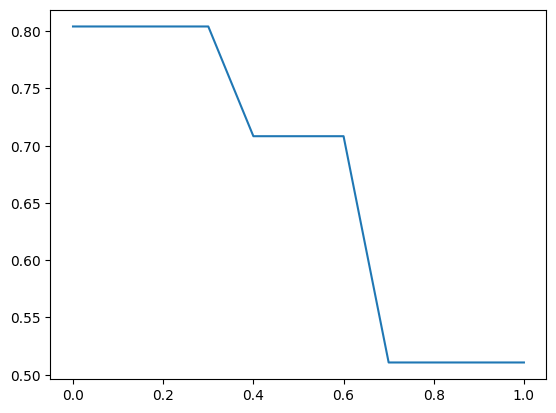

In [25]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 1.3. [10] Normalized Discounted Cumulative Gain

NDCG metric is designed for situations of non-binary notions of relevance. It is evaluated over some number $k$ of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries $Q$, let $R(j,d)$ be the relevance score assessors gave to document $d$ for query $j$. Then,

![](https://i.imgur.com/LLogCYa.png)

where $Z_{kj}$ is a normalization factor calculated to make it so that a perfect ranking’s NDCG at $k$ for query $j$ is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

### The issue with (5-rel) have been existing for two years at least. Please fix it for future students 

In [26]:
def score5(search_result, relevance):
    N = len(search_result)
    relevance = np.array(relevance)
    relev = np.zeros(N) + 5
    relev[relevance[:, 0] - 1] = relevance[:, 1]
    return 5 - relev[np.array(search_result) - 1]

def DCG(search_result, relevance):
    return np.sum((np.power(2, score5(search_result, relevance)) - 1) / np.log2(1 + np.arange(1, 1 + len(search_result))))

def IDCG(search_result, relevance):
    n = len(relevance)
    s5 = np.sort(score5(search_result, relevance))[::-1]
    return np.sum((np.power(2, s5) - 1)[:n] / np.log2(1 + np.arange(1, 1 + n)))

def NDCG(search_results, relevance):    
    zipped = [(search_results[i], relevance[i + 1]) for i in range(len(search_results))]
    outputs = []    
    for result, relev in zipped:
        outputs.append(DCG(result, relev) / IDCG(result, relev))
    return np.mean(outputs).astype(np.float64)

In [27]:
score5(test_results[0], test_relevance[1])

array([0., 0., 0., 0., 3., 0., 2., 4., 0., 0.])

### 1.3.1. Tests

In [28]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633275


## 1.4. [15] pFound ## 
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [29]:
pBreak = .15
pRel = .4
def pFound(search_results, relevance):
    results = []
    for result, (_, relev) in zip(search_results, sorted(relevance.items(), key=lambda x: x[0])):
        relev = mask_relevance(result, relev) * pRel
        pLook = 1
        pFound = pLook * relev[0]
        for i in range(1, len(relev)):
            pLook = pLook * (1 - pBreak) * (1 - relev[i-1])
            pFound += pLook * relev[i]
        results.append(pFound)
    return np.mean(results).astype(np.float64)

### 1.4.1. Tests

In [30]:
pFound_test = pFound(test_results, test_relevance)
print("pFound", pFound_test)
assert np.isclose(pFound_test, 0.582, atol=1e-03)
assert pFound(test_results[:5], test_relevance) > pFound(test_results[5:10], test_relevance)

pFound 0.5821558180674999


Have a nice day! :)